# Consensus Analysis of Ensemble inner model

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import pysam
import logomaker
from tqdm import tqdm

# add parent folder of the C_to_U_classifier_plus_min package to path in order to be loaded into the current session
sys.path.append("/lustrehome/afonzino")

from C_to_U_classifier_plus_min.utils import create_sequence_logo, get_rev_compl


def produce_consensus(df, title, interval, ref_filepath):
    with tqdm(total=df.shape[0]) as pbar:
        refs = []
        ref = pysam.FastaFile(ref_filepath)
        for site in df.itertuples():
            region = site[1]
            pos1based = site[2]
            pos0based = pos1based-1
            strand = site[3]
            reference = ref.fetch(region, pos0based-interval, pos0based+interval+1)
            if strand == "+":
                refs.append(list(reference))
            elif strand == "-":
                reference = get_rev_compl(reference)
                refs.append(list(reference))
            pbar.update(1)
    ref.close()
    
    refs = pd.DataFrame(refs, columns=[f"{i}" for i in range(interval*2+1)])
    refs_freqs = {}
    for rel_pos in refs:
        refs_freqs[int(rel_pos)] = refs[rel_pos].value_counts().sort_index()
    refs = pd.DataFrame(refs_freqs).fillna(0)
    depths = refs.sum().tolist()
    refs = refs / depths
    refs = refs.T

    create_sequence_logo(refs, title=f"{title}")

In [2]:
# define inputs of SNPs, m5C and APOBEC1 filtered sites 
ref_mm39_filepath = "/lustre/bio_running/C_to_U_editing/refs/GRCm39.primary_assembly.genome.fa"
wt_dfCTaggr_basecall_filepath = "/lustre/bio_running/C_to_U_editing_minimap2_spliced/src_jupyter_notebooks_multi_thr//wt_ko/wt_iForest_and_SNP_m5C_filtered_snp142.apobec1.tsv"
wt_dfCTaggr_currents_filepath = "/lustre/bio_running/C_to_U_editing_minimap2_spliced/src_jupyter_notebooks_multi_thr//wt_ko/wt_ko.CNN_wavenet_08/wt_CNNwavenet_and_SNP_m5C_filtered_snp142.apobec1.tsv"
ko_dfCTaggr_basecall_filepath = "/lustre/bio_running/C_to_U_editing_minimap2_spliced/src_jupyter_notebooks_multi_thr//wt_ko/ko_iForest_and_SNP_m5C_filtered_snp142.apobec1.tsv"
ko_dfCTaggr_currents_filepath = "/lustre/bio_running/C_to_U_editing_minimap2_spliced/src_jupyter_notebooks_multi_thr//wt_ko/wt_ko.CNN_wavenet_08/ko_CNNwavenet_and_SNP_m5C_filtered_snp142.apobec1.tsv"

## WT

In [3]:
wt_dfCTaggr_basecall = pd.read_table(wt_dfCTaggr_basecall_filepath, index_col=0)
wt_dfCTaggr_basecall

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat,p_value
0,chr1,4915426,+,2,2,51,0.039216,0.039216,TGCAT,1,0.001079
1,chr1,4915443,+,5,3,54,0.092593,0.055556,TACAA,1,0.000049
2,chr1,4915467,+,5,4,55,0.090909,0.072727,TACAG,1,0.005247
3,chr1,4915694,+,7,4,51,0.137255,0.078431,TACTA,1,0.000521
4,chr1,4915760,+,2,2,58,0.034483,0.034483,GTCAA,1,0.009496
...,...,...,...,...,...,...,...,...,...,...,...
1537,chrX,154115400,-,9,4,125,0.072000,0.032000,TACTG,1,0.000807
1538,chrX,156228730,-,5,3,60,0.083333,0.050000,GACTT,1,0.002032
1539,chrX,158165691,+,6,4,125,0.048000,0.032000,ATCAA,1,0.000734
1540,chrX,161555202,+,23,10,124,0.185484,0.080645,GACTG,1,0.000465


In [4]:
wt_dfCTaggr_currents = pd.read_table(wt_dfCTaggr_currents_filepath, index_col=0)
wt_dfCTaggr_currents

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat,p_value
0,chr1,4915457,+,4,2,51,0.078431,0.039216,TACTA,1,0.000047
1,chr1,4915694,+,7,2,51,0.137255,0.039216,TACTA,1,0.000521
2,chr1,4916328,+,2,2,60,0.033333,0.033333,ATCTT,1,0.000028
3,chr1,4916336,+,20,18,67,0.298507,0.268657,GCCGA,1,0.000316
4,chr1,4916406,+,3,3,67,0.044776,0.044776,GACTT,1,0.000099
...,...,...,...,...,...,...,...,...,...,...,...
1586,chrX,141022514,+,4,1,54,0.074074,0.018519,AACAG,1,0.000286
1587,chrX,141022655,+,3,1,52,0.057692,0.019231,AACTT,1,0.000013
1588,chrX,153996147,-,8,1,62,0.129032,0.016129,TACTC,1,0.000004
1589,chrX,158165691,+,6,4,125,0.048000,0.032000,ATCAA,1,0.000734


In [5]:
# aggregate and produce ensemble prediction
wt_dfCTaggr_ensemble = pd.merge(wt_dfCTaggr_basecall.query("y_hat == 1"), wt_dfCTaggr_currents.query("y_hat == 1"), on=["region", "position", "strand"], how="inner")
wt_dfCTaggr_ensemble

,region,position,strand,T_native_x,T_corrected_x,depth_stranded_x,Tfreq_native_x,Tfreq_corrected_x,5mer_x,y_hat_x,p_value_x,T_native_y,T_corrected_y,depth_stranded_y,Tfreq_native_y,Tfreq_corrected_y,5mer_y,y_hat_y,p_value_y
0,chr1,4915694,+,7,4,51,0.137255,0.078431,TACTA,1,0.000521,7,2,51,0.137255,0.039216,TACTA,1,0.000521
1,chr1,4916336,+,20,4,67,0.298507,0.059701,GCCGA,1,0.000316,20,18,67,0.298507,0.268657,GCCGA,1,0.000316
2,chr1,4916406,+,3,3,67,0.044776,0.044776,GACTT,1,0.000099,3,3,67,0.044776,0.044776,GACTT,1,0.000099
3,chr1,4967180,+,7,3,108,0.064815,0.027778,TACTC,1,0.000004,5,2,108,0.046296,0.018519,TACTC,1,0.000004
4,chr1,4967189,+,11,4,114,0.096491,0.035088,AACGG,1,0.000003,9,4,114,0.078947,0.035088,AACGG,1,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,chrX,135147776,+,15,12,56,0.267857,0.214286,AACTT,1,0.000023,15,9,56,0.267857,0.160714,AACTT,1,0.000023
389,chrX,135147837,+,11,7,52,0.211538,0.134615,AACAC,1,0.001189,11,3,52,0.211538,0.057692,AACAC,1,0.001189
390,chrX,135633808,-,38,11,126,0.301587,0.087302,AACAT,1,0.008177,35,3,126,0.277778,0.023810,AACAT,1,0.008177
391,chrX,153996147,-,8,3,62,0.129032,0.048387,TACTC,1,0.000004,8,1,62,0.129032,0.016129,TACTC,1,0.000004


In [6]:
wt_dfCTaggr_ensemble.query("position == 121983221")

,region,position,strand,T_native_x,T_corrected_x,depth_stranded_x,Tfreq_native_x,Tfreq_corrected_x,5mer_x,y_hat_x,p_value_x,T_native_y,T_corrected_y,depth_stranded_y,Tfreq_native_y,Tfreq_corrected_y,5mer_y,y_hat_y,p_value_y
201,chr2,121983221,+,280,166,851,0.329025,0.195065,TACAC,1,0.004419,254,9,851,0.298472,0.010576,TACAC,1,0.004419


In [7]:
# write to disk snp and m5C filtered sites called by ensemble classifier on WT sample
wt_dfCTaggr_ensemble.to_csv("wt_ENSEMBLE_and_SNP_m5C_filtered_snp142.apobec1.tsv", sep="\t")

100%|██████████| 393/393 [00:30<00:00, 12.78it/s]
findfont: Font family ['Arial Rounded MT Bold'] not found. Falling back to DejaVu Sans.


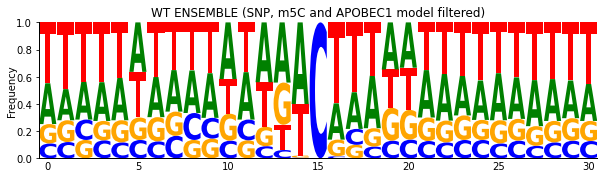

In [8]:
produce_consensus(wt_dfCTaggr_ensemble, "WT ENSEMBLE (SNP, m5C and APOBEC1 model filtered)", 15, ref_mm39_filepath)

## KO

In [9]:
ko_dfCTaggr_basecall = pd.read_table(ko_dfCTaggr_basecall_filepath, index_col=0)
ko_dfCTaggr_basecall

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat,p_value
0,chr1,4916168,+,13,2,96,0.135417,0.020833,AACTG,1,0.001260
1,chr1,4916319,+,9,2,87,0.103448,0.022989,TTCTT,1,0.000316
2,chr1,4916336,+,25,7,104,0.240385,0.067308,GCCGA,1,0.000316
3,chr1,4963782,+,12,3,90,0.133333,0.033333,TACAC,1,0.001785
4,chr1,4967134,+,8,2,96,0.083333,0.020833,TTCTT,1,0.001192
...,...,...,...,...,...,...,...,...,...,...,...
1107,chrX,156228730,-,5,3,68,0.073529,0.044118,GACTT,1,0.002032
1108,chrX,158168406,+,13,6,164,0.079268,0.036585,ATCTA,1,0.001369
1109,chrX,161552918,+,9,5,175,0.051429,0.028571,AACAC,1,0.005402
1110,chrX,161561670,+,21,6,218,0.096330,0.027523,AACTG,1,0.001552


In [10]:
ko_dfCTaggr_currents = pd.read_table(ko_dfCTaggr_currents_filepath, index_col=0)
ko_dfCTaggr_currents

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat,p_value
0,chr1,4916252,+,3,1,91,0.032967,0.010989,AACAC,1,0.000367
1,chr1,4916336,+,24,20,104,0.230769,0.192308,GCCGA,1,0.000316
2,chr1,4967787,+,11,5,133,0.082707,0.037594,AACAT,1,0.004150
3,chr1,5206037,+,1,1,83,0.012048,0.012048,CTCAT,1,0.000248
4,chr1,5232494,+,24,3,68,0.352941,0.044118,TTCTG,1,0.000028
...,...,...,...,...,...,...,...,...,...,...,...
1184,chrX,135633974,-,8,3,184,0.043478,0.016304,TGCAT,1,0.001077
1185,chrX,141022343,+,8,1,54,0.148148,0.018519,CTCAT,1,0.002212
1186,chrX,161555354,+,7,7,175,0.040000,0.040000,AACTT,1,0.005799
1187,chrX,161560774,+,8,2,176,0.045455,0.011364,TTCAT,1,0.008214


In [11]:
# aggregate and produce ensemble prediction
ko_dfCTaggr_ensemble = pd.merge(ko_dfCTaggr_basecall.query("y_hat == 1"), ko_dfCTaggr_currents.query("y_hat == 1"), on=["region", "position", "strand"], how="inner")
ko_dfCTaggr_ensemble

,region,position,strand,T_native_x,T_corrected_x,depth_stranded_x,Tfreq_native_x,Tfreq_corrected_x,5mer_x,y_hat_x,p_value_x,T_native_y,T_corrected_y,depth_stranded_y,Tfreq_native_y,Tfreq_corrected_y,5mer_y,y_hat_y,p_value_y
0,chr1,4916336,+,25,7,104,0.240385,0.067308,GCCGA,1,0.000316,24,20,104,0.230769,0.192308,GCCGA,1,0.000316
1,chr1,13635485,-,10,4,146,0.068493,0.027397,AACAG,1,0.005320,9,2,146,0.061644,0.013699,AACAG,1,0.005320
2,chr1,39590524,-,18,4,87,0.206897,0.045977,CTCGC,1,0.003903,18,6,87,0.206897,0.068966,CTCGC,1,0.003903
3,chr1,45856512,+,25,10,66,0.378788,0.151515,TACTG,1,0.009936,25,4,66,0.378788,0.060606,TACTG,1,0.009936
4,chr1,58444643,+,46,7,183,0.251366,0.038251,TTCAA,1,0.005889,44,6,183,0.240437,0.032787,TTCAA,1,0.005889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,chrX,74152885,+,25,5,68,0.367647,0.073529,CTCTG,1,0.000898,25,5,68,0.367647,0.073529,CTCTG,1,0.000898
200,chrX,74153973,-,3,2,84,0.035714,0.023810,AACTT,1,0.003488,3,2,84,0.035714,0.023810,AACTT,1,0.003488
201,chrX,100491909,+,18,6,148,0.121622,0.040541,ATCTT,1,0.001359,18,10,148,0.121622,0.067568,ATCTT,1,0.001359
202,chrX,135633808,-,51,9,149,0.342282,0.060403,AACAT,1,0.008177,50,10,149,0.335570,0.067114,AACAT,1,0.008177


In [12]:
# write to disk snp and m5C filtered sites called by ensemble classifier on KO sample
ko_dfCTaggr_ensemble.to_csv("ko_ENSEMBLE_and_SNP_m5C_filtered_snp142.apobec1.tsv", sep="\t")

100%|██████████| 204/204 [00:10<00:00, 19.17it/s]


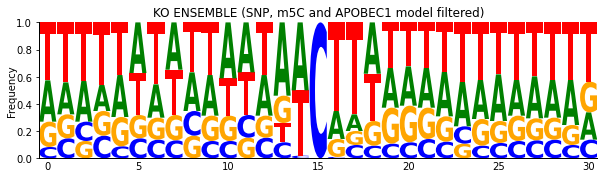

In [13]:
produce_consensus(ko_dfCTaggr_ensemble, "KO ENSEMBLE (SNP, m5C and APOBEC1 model filtered)", 15, ref_mm39_filepath)

## Evaluate reliable CtoU editing sites
To eliminate RNA-DNA problems we focused out attention on sites that are modified in WT but that are not in KO sample

In [14]:
# retrieve all edited position for ensemble KO
ko_ed_ensemble = set()
for site in ko_dfCTaggr_ensemble.itertuples():
    ko_ed_ensemble.add(f"{site[1]}:{site[2]}")
ko_ed_ensemble

{'chr10:111332451',
 'chr10:24063986',
 'chr10:61527218',
 'chr10:71063929',
 'chr10:71166585',
 'chr10:87767313',
 'chr10:88579409',
 'chr10:90985261',
 'chr10:90985314',
 'chr11:113554072',
 'chr11:116740868',
 'chr11:120485512',
 'chr11:20175404',
 'chr11:29692760',
 'chr11:52137457',
 'chr11:52279367',
 'chr11:5475768',
 'chr11:75656275',
 'chr12:110824642',
 'chr12:25144015',
 'chr12:31381917',
 'chr12:37631832',
 'chr12:40253258',
 'chr12:69624446',
 'chr12:80997047',
 'chr12:83778459',
 'chr12:8988690',
 'chr13:100791936',
 'chr13:47239357',
 'chr13:58325372',
 'chr14:113554102',
 'chr14:19862424',
 'chr14:20506325',
 'chr14:21498209',
 'chr15:100518560',
 'chr15:34140950',
 'chr15:34141435',
 'chr15:34141462',
 'chr15:38490438',
 'chr15:51659870',
 'chr15:51826565',
 'chr15:51827338',
 'chr15:81261996',
 'chr15:99534017',
 'chr16:20500563',
 'chr16:32450043',
 'chr16:32450364',
 'chr16:35872770',
 'chr16:43980153',
 'chr16:44659173',
 'chr16:4525532',
 'chr16:56526049',
 'chr17

In [15]:
# retrieve all edited position for ensemble WT
wt_ed_ensemble = set()
for site in wt_dfCTaggr_ensemble.itertuples():
    wt_ed_ensemble.add(f"{site[1]}:{site[2]}")
wt_ed_ensemble

{'chr10:116898786',
 'chr10:117651283',
 'chr10:128197551',
 'chr10:17601044',
 'chr10:17887230',
 'chr10:40163958',
 'chr10:57392081',
 'chr10:57392155',
 'chr10:60934764',
 'chr10:62291762',
 'chr10:71166603',
 'chr10:88579179',
 'chr10:88579284',
 'chr10:88579409',
 'chr10:88579439',
 'chr10:90952683',
 'chr10:93696816',
 'chr10:93704813',
 'chr10:96454514',
 'chr11:106677281',
 'chr11:116740868',
 'chr11:120485512',
 'chr11:16921473',
 'chr11:16923978',
 'chr11:21507268',
 'chr11:29692828',
 'chr11:40630550',
 'chr11:50185437',
 'chr11:50186566',
 'chr11:50276961',
 'chr11:51680148',
 'chr11:52133479',
 'chr11:52279367',
 'chr11:5475768',
 'chr11:69571672',
 'chr11:75656275',
 'chr11:83117131',
 'chr11:86595630',
 'chr11:87941635',
 'chr11:87941760',
 'chr11:97052435',
 'chr11:98886196',
 'chr12:110824690',
 'chr12:111511304',
 'chr12:112620279',
 'chr12:25144015',
 'chr12:28731724',
 'chr12:31390378',
 'chr12:31646149',
 'chr12:32900839',
 'chr12:32900899',
 'chr12:3298050',
 'chr

In [16]:
reliable_ensemble = wt_ed_ensemble.difference(ko_ed_ensemble)
len(reliable_ensemble)

343

In [17]:
# produce a dataframe
reliable_ensemble_df = pd.merge(wt_dfCTaggr_ensemble, 
                                pd.DataFrame([[site.split(":")[0], int(site.split(":")[1])] for site in reliable_ensemble], columns=["region", "position"]),
                                how="inner",
                                on=["region", "position"])
reliable_ensemble_df

,region,position,strand,T_native_x,T_corrected_x,depth_stranded_x,Tfreq_native_x,Tfreq_corrected_x,5mer_x,y_hat_x,p_value_x,T_native_y,T_corrected_y,depth_stranded_y,Tfreq_native_y,Tfreq_corrected_y,5mer_y,y_hat_y,p_value_y
0,chr1,4915694,+,7,4,51,0.137255,0.078431,TACTA,1,0.000521,7,2,51,0.137255,0.039216,TACTA,1,0.000521
1,chr1,4916406,+,3,3,67,0.044776,0.044776,GACTT,1,0.000099,3,3,67,0.044776,0.044776,GACTT,1,0.000099
2,chr1,4967180,+,7,3,108,0.064815,0.027778,TACTC,1,0.000004,5,2,108,0.046296,0.018519,TACTC,1,0.000004
3,chr1,4967189,+,11,4,114,0.096491,0.035088,AACGG,1,0.000003,9,4,114,0.078947,0.035088,AACGG,1,0.000003
4,chr1,4967193,+,6,3,112,0.053571,0.026786,GACTT,1,0.000011,5,2,112,0.044643,0.017857,GACTT,1,0.000011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,chrX,108206054,+,2,2,96,0.020833,0.020833,TTCAA,1,0.000939,2,1,96,0.020833,0.010417,TTCAA,1,0.000939
339,chrX,135147776,+,15,12,56,0.267857,0.214286,AACTT,1,0.000023,15,9,56,0.267857,0.160714,AACTT,1,0.000023
340,chrX,135147837,+,11,7,52,0.211538,0.134615,AACAC,1,0.001189,11,3,52,0.211538,0.057692,AACAC,1,0.001189
341,chrX,153996147,-,8,3,62,0.129032,0.048387,TACTC,1,0.000004,8,1,62,0.129032,0.016129,TACTC,1,0.000004


In [18]:
# save to disk
reliable_ensemble_df.to_csv("reliable_ed_pos_ensembl.apobec1.tsv", sep="\t", index=None)

In [ ]:
# produce consensus for reliable edited position from enseble models
produce_consensus(reliable_ensemble_df, "Reliable edited sites from WT and KO ensemble models (SNP, m5C and APOBEC1 model filtered)", 15, ref_mm39_filepath)

100%|██████████| 343/343 [00:00<00:00, 21761.40it/s]
